 # Notebook description

In this notebook the analysis is continued but this time flight table is combine with other tables

 Libraries import and loading enviroment variables

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import plotly.express as px
from dotenv import load_dotenv
from os import environ

In [2]:
dotenv_path = '../.env'
load_dotenv(dotenv_path)

True

In [3]:
username = environ.get('db_username')
password = environ.get('db_password')

host = environ.get('db_host')
database = environ.get('db_database')
port = environ.get('db_port')

Creating connection variables

In [4]:
url = URL.create(
    "postgresql",
    username=username,
    password=password,
    host=host,
    database=database,
)
engine = create_engine(url)

Creating function that downloads data from database into dataframe

In [5]:
def read_sql_table(tablename):
    return pd.read_sql(f'select * from {tablename}', engine)

Uploading flight dataframe from pickle file

In [6]:
flight_df = pd.read_pickle(r'..\data\processed\flight_df_01.pk1')
flight_df.head(1)

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019,0,1


 # Adding data from 'aircraft' table to flight dataframe

Uploading 'aircraft' table to dataframe

In [7]:
aircraft_df = read_sql_table('aircraft')
aircraft_df.head()

,id,manufacture_year,tail_num,number_of_seats
0,1,1944,N54514,0.0
1,2,1945,N1651M,0.0
2,3,1953,N100CE,0.0
3,4,1953,N141FL,0.0
4,5,1953,N151FL,0.0


Dropping 'number_of_seats' and 'id' columns and duplicates

In [8]:
aircraft_df = aircraft_df.drop(columns = ['id', 'number_of_seats'])
aircraft_df = aircraft_df.drop_duplicates()
aircraft_df.head()

,manufacture_year,tail_num
0,1944,N54514
1,1945,N1651M
2,1953,N100CE
3,1953,N141FL
4,1953,N151FL


Checking if there are duplicates in aircraft_df so if there's tail number that has two manufacture years

In [9]:
aircraft_df_is_duplicated = aircraft_df.duplicated(subset='tail_num')
aircraft_df_duplicated = aircraft_df.loc[aircraft_df_is_duplicated]
aircraft_df_duplicated.head()

,manufacture_year,tail_num
2086,2000,N783CA
5725,2014,N856GT
6746,2017,N877AS


Dropping duplicates so the most recent manufacture year is kept

In [10]:
aircraft_df = aircraft_df.sort_values('manufacture_year').drop_duplicates(
    'tail_num', 
    keep = 'last')

Adding aircraft data to flight_df

In [11]:
tmp_flight_df = flight_df.merge(aircraft_df, on = 'tail_num', how = 'left')
tmp_flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,manufacture_year
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,5,NaN,NaN,NaN,NaN,NaN,2019,0,1,2005.0
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,5,NaN,NaN,NaN,NaN,NaN,2019,0,1,2016.0
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,5,4.0,0.0,10.0,0.0,3.0,2019,0,1,1998.0
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,5,NaN,NaN,NaN,NaN,NaN,2019,0,1,1998.0
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,3,NaN,NaN,NaN,NaN,NaN,2019,0,1,2001.0


Checking duplicates

In [12]:
tmp_flight_df_duplicated = tmp_flight_df.duplicated()
tmp_flight_df_duplicated = tmp_flight_df.loc[tmp_flight_df_duplicated]
tmp_flight_df_duplicated

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,manufacture_year


Saving data to flight dataframe

In [13]:
flight_df = tmp_flight_df.copy()

 ## Delays vs manufacture year

In [14]:
delays_by_manufacture_year_df = flight_df.loc[:,['manufacture_year', 'is_delayed']]
delays_by_manufacture_year_df_grouped = delays_by_manufacture_year_df.groupby('manufacture_year').agg(['mean', 'count']).reset_index()
delays_by_manufacture_year_df_grouped.columns = delays_by_manufacture_year_df_grouped.columns.map('{0[0]}|{0[1]}'.format) 

delays_by_manufacture_year_df_grouped['is_delayed|mean'] = round(delays_by_manufacture_year_df_grouped['is_delayed|mean'] * 100, 2)
delays_by_manufacture_year_df_grouped.head()

,manufacture_year|,is_delayed|mean,is_delayed|count
0,1987.0,12.64,443
1,1988.0,18.14,634
2,1989.0,15.38,13
3,1990.0,15.55,4786
4,1991.0,18.18,7701


Making lineplot of delays in realtion to the year in which a plane was manufactured

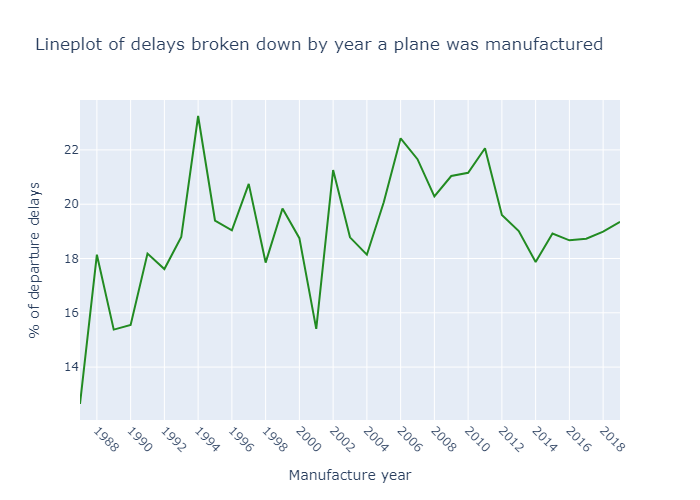

In [15]:
fig_my_delay = px.line(delays_by_manufacture_year_df_grouped,
                      x='manufacture_year|',
                      y = 'is_delayed|mean',
                      title='Lineplot of delays broken down by year a plane was manufactured',
                      color_discrete_sequence = ['forestgreen'])
fig_my_delay.update_layout(xaxis_title="Manufacture year", yaxis_title="% of departure delays")
fig_my_delay.update_xaxes(dtick = 2, tickangle=45)

fig_my_delay.show('png')

Modifying the plot to show only planes that had over 10000 flights

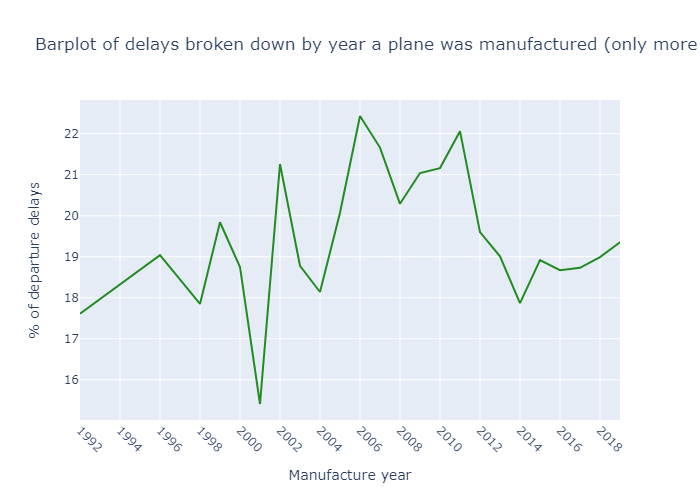

In [16]:
delays_by_manufacture_year_df_grouped_2 = delays_by_manufacture_year_df_grouped.loc[
    delays_by_manufacture_year_df_grouped['is_delayed|count'] > 10000
]

fig_my_delay_2 = px.line(delays_by_manufacture_year_df_grouped_2,
                      x='manufacture_year|',
                      y = 'is_delayed|mean',
                      title='Barplot of delays broken down by year a plane was manufactured (only more than 10000 flights)',
                      color_discrete_sequence = ['forestgreen'])
fig_my_delay_2.update_layout(xaxis_title="Manufacture year", yaxis_title="% of departure delays")
fig_my_delay_2.update_xaxes(dtick = 2, tickangle=45)

fig_my_delay_2.show('png')

Based on the last plot there's no relation between delays and manufacture year

 ## Delays vs manufacture year part 2

Adding a column with bins based on manufacture year with the size of 3 years

In [17]:
bins = pd.interval_range(start = int(min(flight_df['manufacture_year'])), end = int(max(flight_df['manufacture_year'])), freq = 3)

flight_df['manufacture_year_agg'] = pd.cut(flight_df['manufacture_year'], bins).astype('str')

flight_df.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,is_delayed,is_weekend,manufacture_year,manufacture_year_agg
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,NaN,NaN,NaN,NaN,NaN,2019,0,1,2005.0,"(2002, 2005]"
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,NaN,NaN,NaN,NaN,NaN,2019,0,1,2016.0,"(2014, 2017]"
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,4.0,0.0,10.0,0.0,3.0,2019,0,1,1998.0,"(1996, 1999]"
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,NaN,NaN,NaN,NaN,NaN,2019,0,1,1998.0,"(1996, 1999]"
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,NaN,NaN,NaN,NaN,NaN,2019,0,1,2001.0,"(1999, 2002]"


Grouping delays by manufacture year aggregated

In [18]:
flight_delays_by_manufacture_year_agg_df = flight_df.loc[:,['manufacture_year_agg', 'is_delayed']]

flight_delays_by_manufacture_year_agg_df = flight_delays_by_manufacture_year_agg_df.groupby('manufacture_year_agg').mean().reset_index()

flight_delays_by_manufacture_year_agg_df['is_delayed'] = round(flight_delays_by_manufacture_year_agg_df['is_delayed'] * 100, 2)

flight_delays_by_manufacture_year_agg_df.head()

,manufacture_year_agg,is_delayed
0,"(1987, 1990]",15.85
1,"(1990, 1993]",18.01
2,"(1993, 1996]",20.02
3,"(1996, 1999]",19.07
4,"(1999, 2002]",17.49


Creating a barplot of delays in relation to aggregated manufacture year

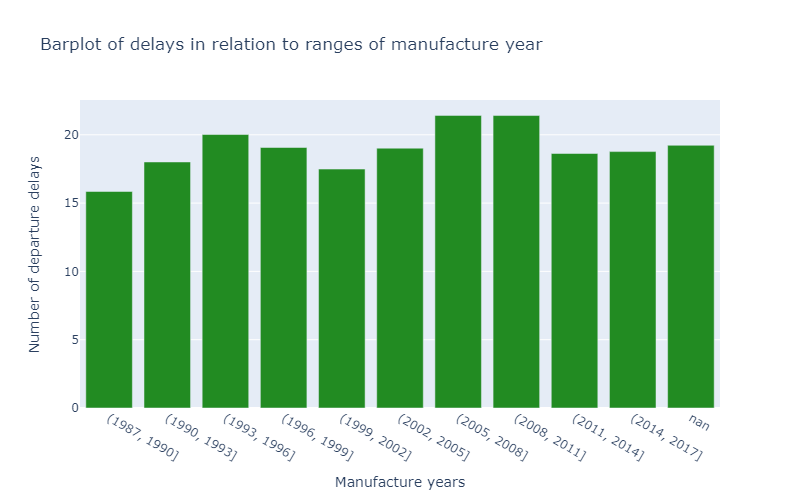

In [19]:
fig_my_delay_range = px.bar(flight_delays_by_manufacture_year_agg_df,
                      x='manufacture_year_agg',
                      y = 'is_delayed',
                      title='Barplot of delays in relation to ranges of manufacture year',
                      color_discrete_sequence = ['forestgreen'], 
                      width = 800, 
                      height = 500)
fig_my_delay_range.update_layout(xaxis_title="Manufacture years", yaxis_title="Number of departure delays")
fig_my_delay_range.update_xaxes(dtick = 'manufacture_year', type='category')
fig_my_delay_range.show('png')

Top 5 manufacture years by number of flights with delay percent

In [20]:
number_of_flights_year_top = delays_by_manufacture_year_df_grouped.nlargest(5, 'is_delayed|count').sort_values('is_delayed|count', ascending = False)
number_of_flights_year_top.columns = ['manufacture_year', 'percent_of_delays', 'num_of_flights']
number_of_flights_year_top

,manufacture_year,percent_of_delays,num_of_flights
14,2001.0,15.41,100251
29,2016.0,18.67,66191
30,2017.0,18.73,62353
27,2014.0,17.87,61128
28,2015.0,18.92,58426


Manufacture year doesn't affect number of delays

Saving dataframe to pickle to retrieve in the next notebook

In [21]:
flight_df.to_pickle(r'..\data\processed\flight_df_01.pk1')